In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier

from xgboost import XGBClassifier, plot_importance

In [56]:
train_data = pd.read_csv('./data/train.csv')
train_y = train_data.target
train_x = pd.DataFrame(train_data.drop(["target", "ID_code"], axis=1)).reset_index(drop=True)

In [25]:
test_data = pd.read_csv('./data/test.csv')

In [26]:
sub = pd.read_csv('./data/sample_submission.csv')

In [8]:
summary = train_data.describe()

Text(0.5, 1.0, 'Histogram of all predictors')

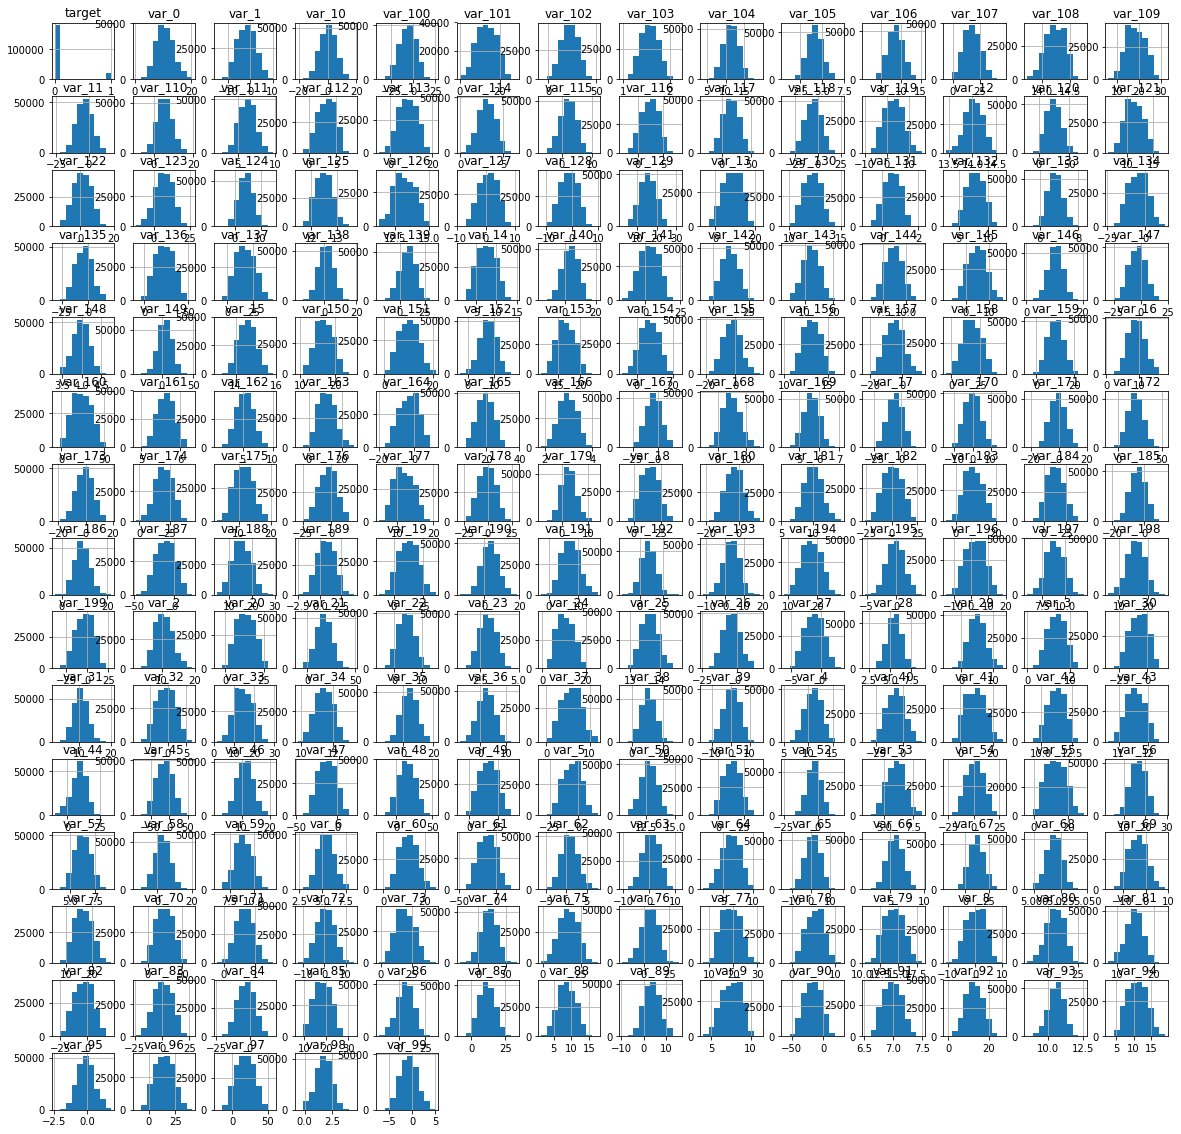

In [12]:
train_data.hist(figsize = (20,20))

plt.tight_layout
plt.title("Histogram of all predictors")

In [ ]:
train_data.isnull().sum().sum()

In [ ]:
fig = sns.countplot("target", data=train_data)

fig.get_figure().savefig("classImbalance.png")

In [ ]:
summary.columns

In [ ]:
summary.var_0

#### Model Building

I don't think there is any more exploratory needed to be built as the data is normalized to an extent and we can go into the assumption that they are all related.

#### Logistic Regression

In [ ]:
logRModel = LogisticRegression(random_state=0).fit(train_x, train_y)

In [ ]:
logRModel.score(train_x, train_y)

In [57]:
ID_Code = test_data["ID_code"]
test_x = pd.DataFrame(test_data.drop(["ID_code"], axis=1)).reset_index(drop=True)

In [ ]:
predictions = logRModel.predict(test_x)

In [ ]:
test_x


In [ ]:
sub["target"] = predictions
sub.to_csv("logistic_model_predictions.csv", index=False)

#### Result - 0.630 ROC

### Upsampling data

In [ ]:
#Install imblearn: conda install -c conda-forge imbalanced-learn 
c

In [46]:
print("Before OverSampling, counts of label '1': {}".format(sum(train_y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(train_y==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(train_x, train_y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 20098
Before OverSampling, counts of label '0': 179902 

After OverSampling, the shape of train_X: (359804, 200)
After OverSampling, the shape of train_y: (359804,) 

After OverSampling, counts of label '1': 179902
After OverSampling, counts of label '0': 179902


In [ ]:
X_train_datadf=pd.DataFrame(X_train_res)

### Logistic Implementation- with upsampled data - lesser score - 0.778 ROC


In [ ]:
logr = LogisticRegression(random_state=0)
logr_model_ud =logr.fit(X_train_datadf, y_train_res)

predictions = logr_model_ud.predict(test_x)
sub["target"] = predictions
sub.to_csv("logistic_ud.csv", index=False)

logRModel.score(train_x, train_y)

### LDA Implementation - with upsampled data -  score - 0.778 ROC

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_model_ud = lda.fit(X_train_datadf, y_train_res)
lda_score_ud = lda_model_ud.score(X_train_datadf, y_train_res)
sub["target"] = lda_model_ud.predict(test_x)
sub.to_csv("lda1.csv", index=False)
lda_score_ud

### LDA Implementation -without upsampling - 0.635 ROC

In [ ]:
lda = LinearDiscriminantAnalysis()
lda_model = lda.fit(train_x, train_y)
lda_score = lda_model.score(train_x, train_y)
sub["target"] = lda_model.predict(test_x)
sub.to_csv("lda.csv", index=False)
lda_score

###  Exploration of Correlation - Features are not correlated

In [11]:
corrs = train_x.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(20)

,level_0,level_1,0
39780,var_1,var_80,0.008855
39781,var_80,var_1,0.008855
39782,var_172,var_81,0.008936
39783,var_81,var_172,0.008936
39784,var_122,var_132,0.008956
39785,var_132,var_122,0.008956
39786,var_80,var_6,0.008958
39787,var_6,var_80,0.008958
39788,var_146,var_169,0.009071
39789,var_169,var_146,0.009071


### QDA Implementation -without upsampling - 0.635 ROC

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda_model = qda.fit(train_x, train_y)
qda_score = qda_model.score(train_x, train_y)
sub["target"] = qda_model.predict(test_x)
sub.to_csv("qda.csv", index=False)
qda_score

### QDA Implementation -with upsampling - 0.514 ROC

In [ ]:
qda_ud = QuadraticDiscriminantAnalysis()
qda_model_ud = qda_ud.fit(X_train_datadf, y_train_res)
qda_score_ud = qda_model_ud.score(X_train_datadf, y_train_res)
sub["target"] = qda_model_ud.predict(test_x)
sub.to_csv("qda1.csv", index=False)
qda_score_ud

## Ensemble models

### Ensemble GNB. AUC: 0.888

In [ ]:
prediction = np.zeros(len(test_x))
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
res = dict()
nb_clf = GaussianNB()
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    nb_clf.fit(X_train, y_train)
    col_name = "target_" + str(fold_n)
    preds =  nb_clf.predict_proba(test_x)
    res[col_name] = preds
sub['target']=(res['target_0']+res['target_1']+res['target_2']+res['target_3']+res['target_4'])/5
sub.to_csv("ensemble_gnb.csv", index = False)

fpr, tpr, thr = roc_curve(train_y, sub['target'])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic Plot', fontsize=20, y=1.05)
auc(fpr, tpr)

In [7]:
from sklearn.ensemble import AdaBoostClassifier

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=250,learning_rate=0.1)

# Train Adaboost Classifer
model = abc.fit(X_train_datadf, y_train_res)

#Predict the response for test dataset
y_pred = model.predict(test_x)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",model.score(X_train_datadf, y_train_res)

sub["target"] = y_pred
sub.to_csv("adaboost_us.csv", index=False)

NameError: name 'test_x' is not defined

### Ensemble ADA boost: AUC 0.82 

In [21]:
prediction = np.zeros(len(test_x))
n_fold = 6
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
res = dict()
abc = AdaBoostClassifier(n_estimators=250,learning_rate=0.1)
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    abc_model = abc.fit(X_train, y_train)
    col_name = "target_" + str(fold_n)
    preds =  abc_model.predict_proba(test_x)
    res[col_name] = preds
    print("Accuracy:",model.score(X_valid, y_valid))
sub['target']=(res['target_0']+res['target_1']+res['target_2']+res['target_3']+res['target_4']+res['target_5'])/6
sub.to_csv("ensemble_ada.csv", index = False)

Fold 0 started at Sat Apr 13 00:03:01 2019
Accuracy: 0.90766
Fold 1 started at Sat Apr 13 00:18:15 2019
Accuracy: 0.90766
Fold 2 started at Sat Apr 13 00:33:29 2019
Accuracy: 0.90766
Fold 3 started at Sat Apr 13 00:48:43 2019
Accuracy: 0.90766
Fold 4 started at Sat Apr 13 01:03:41 2019
Accuracy: 0.90766
Fold 5 started at Sat Apr 13 01:19:07 2019
Accuracy: 0.90766


### XG Boost

In [7]:
model = XGBClassifier()
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

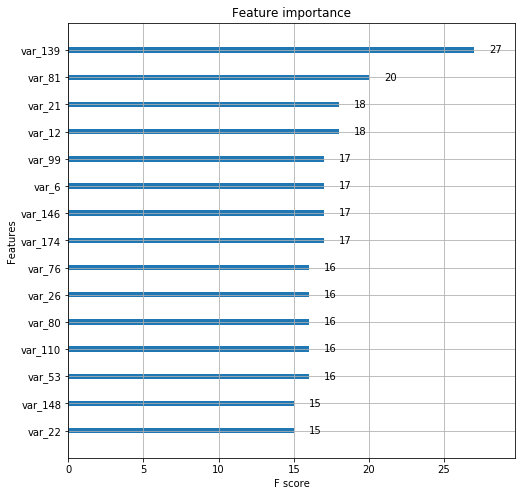

In [20]:
sorted_idx = np.argsort(model.feature_importances_)[::-1]
fig, ax = plt.subplots(1,1,figsize=(8,8)) 
plot_importance(model, max_num_features = 15, ax=ax )
plt.show()

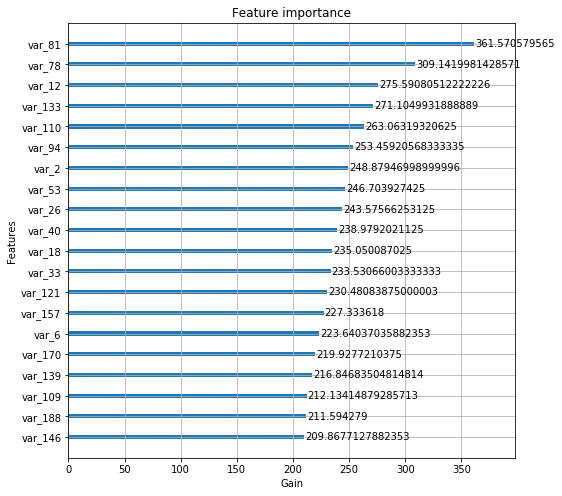

In [22]:
fig, ax = plt.subplots(1,1,figsize=(8,8)) 
xgb.plot_importance(model, max_num_features=20, ax=ax, importance_type="gain", xlabel="Gain")
plt.show()

### AUC 0.87528 (params) and AUC 0.89881(params2)

In [42]:
params_2 = {'tree_method': 'hist',
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'learning_rate': 0.0936165921314771,
 'max_depth': 2,
 'colsample_bytree': 0.3561271102144279,
 'subsample': 0.8246604621518232,
 'min_child_weight': 53,
 'gamma': 9.943467991283027,
 'silent': 1}

params = {
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 2,
    'colsample_bytree': 0.35,
    'subsample': 0.82,
    'min_child_weight': 50,
    'gamma': 10,
    'silent': 1
         }

In [54]:
prediction = np.zeros(len(test_x))
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=7)
res = dict()    
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train_x.iloc[train_index], train_x.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
    dval = xgb.DMatrix(X_valid, y_valid, feature_names=X_valid.columns)  
    clf = xgb.train(params=params_2, dtrain=dtrain, num_boost_round=4000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=50) 
#     oof_preds[val_idx] = clf.predict(xgb.DMatrix(valid_index))
    prediction += clf.predict(xgb.DMatrix(test_x)) / folds.n_splits
#     print("Accuracy:",clf.score(X_valid, y_valid))
sub['target']=prediction
sub.to_csv("ensemble_xgboost_2.csv", index = False)

Fold 0 started at Sat Apr 13 07:14:42 2019
[07:14:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


XGBoostError: b'[07:14:45] src/objective/regression_obj.cc:98: Check failed: Loss::CheckLabel(y) label must be in [0,1] for logistic regression\n\nStack trace returned 8 entries:\n[bt] (0) 0   libxgboost.dylib                    0x0000001a24e8a1fe dmlc::StackTrace() + 254\n[bt] (1) 1   libxgboost.dylib                    0x0000001a24e89faf dmlc::LogMessageFatal::~LogMessageFatal() + 47\n[bt] (2) 2   libxgboost.dylib                    0x0000001a24f09317 xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::LazyCheckLabels(std::__1::vector<float, std::__1::allocator<float> > const&) + 231\n[bt] (3) 3   libxgboost.dylib                    0x0000001a24f08a0a xgboost::obj::RegLossObj<xgboost::obj::LogisticClassification>::GetGradient(xgboost::HostDeviceVector<float>*, xgboost::MetaInfo const&, int, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*) + 682\n[bt] (4) 4   libxgboost.dylib                    0x0000001a24e866d3 xgboost::LearnerImpl::UpdateOneIter(int, xgboost::DMatrix*) + 963\n[bt] (5) 5   libxgboost.dylib                    0x0000001a24ea2eec XGBoosterUpdateOneIter + 172\n[bt] (6) 6   libffi.6.dylib                      0x000000010eb42884 ffi_call_unix64 + 76\n[bt] (7) 7   ???                                 0x00007ffee27f7cc0 0x0 + 140732698426560\n\n'

### Using upsampled data

In [82]:
prediction = np.zeros(len(test_x))
n_fold = 2
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=7)
res = dict()  
train_x_ud = pd.DataFrame(X_train_res)
train_y_ud = pd.DataFrame(y_train_res)
train_x_ud.columns = train_x.columns
train_y_ud.columns = ['target']
train_y_ud = train_y_ud.target
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_x_ud, train_y_ud)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train_x_ud.loc[train_index], train_x_ud.loc[valid_index]
    y_train, y_valid = train_y_ud.loc[train_index], train_y_ud.loc[valid_index]
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
    dval = xgb.DMatrix(X_valid, y_valid, feature_names=X_valid.columns)  
    clf = xgb.train(params=params_2, dtrain=dtrain, num_boost_round=4000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 100, early_stopping_rounds=50) 
#     oof_preds[val_idx] = clf.predict(xgb.DMatrix(valid_index))
    prediction += clf.predict(xgb.DMatrix(test_x)) / folds.n_splits
#     print("Accuracy:",clf.score(X_valid, y_valid))
sub['target']=prediction
sub.to_csv("ensemble_xgboost_3.csv", index = False)

Fold 0 started at Sat Apr 13 07:28:17 2019
[07:28:20] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	Train-auc:0.575524	Val-auc:0.572257
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 50 rounds.
[100]	Train-auc:0.896452	Val-auc:0.890041
[200]	Train-auc:0.921821	Val-auc:0.915759
[300]	Train-auc:0.932193	Val-auc:0.925998
[400]	Train-auc:0.938365	Val-auc:0.93189
[500]	Train-auc:0.942921	Val-auc:0.93612
[600]	Train-auc:0.946448	Val-auc:0.939419
[700]	Train-auc:0.949392	Val-auc:0.942171
[800]	Train-auc:0.951695	Val-auc:0.944133
[900]	Train-auc:0.953673	Val-auc:0.945922
[1000]	Train-auc:0.955347	Val-auc:0.947426
[1100]	Train-auc:0.956866	Val-auc:0.948742
[1200]	Train-auc:0.958221	Val-auc:0.949888
[1300]	Train-auc:0.959402	Val-auc:0.9509
[1400]	Train-auc:0.960423	Val-auc:0.951773
[1500]	Train-auc:0.961318	Val-auc:0.9525
[1600]	Train-auc:0.962187	Val-auc:0.953165
[1700]	